## Chapter 03. Convolution Neural Network

### CIFAR-10 Dataset Classification with CNN

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.1.0+cu118  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
''' 3. CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


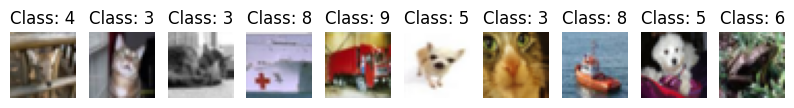

In [7]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

- CNN 모델 설계하기
  - [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2ed), [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool2d#torch.nn.MaxPool2d) 활용한 CNN 모델 구성
  - `nn.Conv2d` : 2차원의 필터를 사용한 convolution 연산 수행
    - `in_channels` : Input 값들의 Channel 수 (최초의 경우 RGB 3 channels, 이후에는 Feature map의 channel 수)
    - `out_channels` : 사용할 Filter의 수
    - `kernel_size` : Filter의 크기 (int or tuple)
    - `padding` : zero padding을 input의 네 면에 몇 층으로 쌓을 것인지에 대한 값
      - `1`이면, 네 면에 한 개의 층을 둘러 쌓는다는 의미

    - Input의 Shape
      - (N, C, H, W)
        - N: Batch size
        - C: Channel 수
        - H, W : Image 혹은 Feature map의 Height, Width

  - `nn.MaxPool2d` : 2차원 공간에서의 Max-pooling 수행

In [8]:
''' 6. Convolutional Neural Network (CNN) 모델 설계하기 '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.log_softmax(x)
        return x

In [9]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [10]:
''' 8. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [11]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
''' 10. CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.301917
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.780395
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.520633
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.425320
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.574425
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.560449
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.634719
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.370683

[EPOCH: 1], 	Test Loss: 0.0439, 	Test Accuracy: 49.25 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.294569
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.413901
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.315747
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.309538
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.245982
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.311229
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.341236
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.437572

[EPOCH: 2], 	Test Loss: 0.0407, 	Test Accuracy: 53.12 % 

### Data Augmentation
- Data augmentation : 기존 이미지에 변형을 주어 변형된 이미지를 이용해 모델 학습
  - 자르기, 회전하기, 반전하기 등 사람의 눈으로 확인했을 때 동일한 클래스로 분류할 수 있는 수준의 변형을 가해야 함

- torchvision 모듈 내 transforms 함수를 활용, augmentation 수행
  - `transforms.Compose()` : 불러오는 이미지 데이터에 전처리 및 augmentation을 다양하게 적용할 때 이용하는 Method
    - `Compose`의 ()안에 있는 처리 과정을 거친 데이터를 불러오게 됨
  - `transforms.RandomHorizontalFlip()` : 해당 이미지를 50% 확률로 좌우 반전
  - `transforms.ToTensor()` : 0-1 정규화(Normalization) + Input을 Tensor 형태로 변환
  - `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` : 평균과 표준편차 활용한 표준화(Standardization)
    - input에서 앞 tuple이 RGB 각각 channel에 대한 평균, 뒤 tuple이 RGB 각각 channel에 대한 표준편차를 의미
  - 예시 : https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
  - doc : https://pytorch.org/vision/stable/transforms.html

In [13]:
''' Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # 각각 RGB 픽셀값에 해당하는 평균과 표준편차를 활용한 표준화

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    # transforms.RandomHorizontalFlip(), # validation / test 데이터셋에서는 augmentation을 수행할 필요가 없음
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [14]:
''' 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

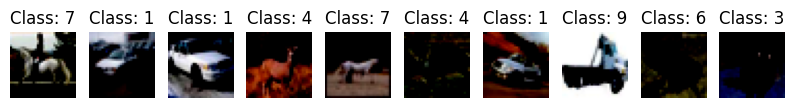

In [15]:
''' 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [16]:
''' Convolutional Neural Network (CNN) 모델 설계하기 '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.log_softmax(x)
        return x

In [17]:
''' Optimizer, Objective Function 설정하기 '''
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [18]:
''' CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [19]:
''' 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
''' CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.295557
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.938136
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.629635
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.588385
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.537852
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.459495
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.589077
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.242239

[EPOCH: 1], 	Test Loss: 0.0429, 	Test Accuracy: 50.54 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.301876
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.303945
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.406836
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.211937
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.328129
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.446139
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.202022
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.897908

[EPOCH: 2], 	Test Loss: 0.0383, 	Test Accuracy: 56.44 % 